In [ ]:
%%capture
from jupyterthemes import jtplot
jtplot.style()
import numpy as np
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 
# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, FlowRouter, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

In [2]:
location = (r'C:/PhD/junk')
os.chdir(location)

input_geotiff = gdal.Open('fann_2013_1m0.tif')
initial_resolution = 1
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
input_DEM = x[1000:,500:]

input_outlets = gdal.Open('g1_grid.tif')
initial_resolution = 1
o = np.array(input_outlets.GetRasterBand(1).ReadAsArray())
outlets = 1 - (o[1000:,500:])

In [ ]:
outlets

In [ ]:
input_DEM = np.array([[100, 100, 100, 100, 100, 100, 100, 100, 100],
                      [90, 80, 70, 50, 30, 50, 70, 80, 90],
                      [80, 60, 40, 30, 20, 30, 40, 60, 80],
                      [70, 55, 35, 25, 0, 25, 35, 55, 70],
                      [60, 45, 25, 20, 10, 20, 25, 45, 60],
                      [50, 35, 15, 0, 0, 10, 15, 35, 50],
                      [40, 25, 10, 7, 0, 7, 10, 25, 40],
                      [30, 15,  5, 4, 1,  4,  5, 15, 30],
                      [20,  5, 3,  3, 2,  3,  3,  5, 20]], dtype = 'Float64')

In [ ]:
plt.imshow(outlets, cmap="gist_earth_r");
plt.colorbar();

In [3]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def slopeWindow(DEM_slope, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM_slope[0]; b = DEM_slope[1]; c = DEM_slope[2]
    d = DEM_slope[3]; e = DEM_slope[4]; f = DEM_slope[5]
    g = DEM_slope[6]; h = DEM_slope[7]; i = DEM_slope[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent
# The 'extra_arguments' variable requires a value that represents r in the PCTL function defined above.
# The reason it need to be assigned to a seperate variable is that the generic_filter function only allows the
# input function (PCTL in this case) to take one argument (S1). Then, if the input function normally 
# takes more than one argument the 'extra_arguments' variable needs to be defined as a tuple 
# (hence (3,) instead of (3)).
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def planCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
    systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    plan_curvature = (2 * (D*(H**2) + E*(G**2) - (F*G*H))) / (G**2 + H**2)
    return plan_curvature
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = (-2 * (D*(G**2) + E*(H**2) + (F*G*H))) / (G**2 + H**2)
    return profile_curvature
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def DFME(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def TWI(slope, As):
    """Calculates Topographic Wetness Index (TWI) taking a slope layer in degrees,
    the catchment area of the cell calculated using a chosen flow routing algorithm and 
    the cell resolution of the slope and catchment area layers input as an integer."""
    tolerance = 1e-16
    slope_radians = np.deg2rad(slope)
    tanB = np.tan(slope_radians)
    tanB[tanB < tolerance] = tolerance
    sca = np.asarray(As)
    sca[sca < tolerance] = tolerance
    W = np.log(np.divide(sca, tanB))
    TWI = np.asarray(W)
    TWI[TWI < tolerance] = 0
    return TWI
def SPI(slope, As):
    """Calculates Compound Topographic Index (TWI) taking a slope layer in degrees and
    the catchment area of the cell calculated using a chosen flow routing algorithm."""
    tolerance = 1e-16
    slope_radians = np.deg2rad(slope)
    tanB = np.tan(slope_radians)
    tanB[tanB < tolerance] = tolerance
    C = np.multiply(As, tanB)
    C_N = np.nan_to_num(C)
    return C_N
def flow_dir_dataset(flow_receivers, grid_node_values, drainage_area,
                     grid_x_axis_length, grid_resolution, grid_shape):
    """Decomposes flow directions into 8 grids of single direction and uses those 
    grids to calculate specific catchment area."""
    array_direction = xr.Dataset();
    # In order - East, North, West, South, Nothwest, Northeast, Southwest, Southeast.
    possible_directions = [1, grid_x_axis_length, -1, -grid_x_axis_length,
                          grid_x_axis_length + 1, grid_x_axis_length - 1,
                            -(grid_x_axis_length + 1), -(grid_x_axis_length -1)]
    for i in range(0,8):
        # Reset the flow_direction grid for each run.
        flow_direction = np.subtract(flow_receivers, grid_node_values);
        # Extract only grids cells with a specific flow direction.
        isolate_direction = flow_direction == possible_directions[i]
        reshape_direction = isolate_direction.reshape(grid_shape)
        weighted_direction = xr.DataArray((np.multiply(drainage_area, reshape_direction)), 
                                          dims = ['lat', 'lon'])
        array_direction[direction_list[i]] = weighted_direction
        
    E, N, W, S, NE, NW, SW, SE = (array_direction['East'],array_direction['North'], 
                                  array_direction['West'], array_direction['South'], 
                                  array_direction['North East'], array_direction['North West'],
                                  array_direction['South West'],array_direction['South East'])

    flow_dirs = xr.concat([E, N, W, S, NE, NW, SW, SE], 'direction')
    flow_dirs.name = 'flow_directions'
    flow_dirs.attrs['grid cell resolution'] = grid_resolution
    flow_directions = flow_dirs.assign_coords(direction=(['East','North','West','South',
                                   'North East', 'North West','South West', 'South East']))
    return flow_directions
def calculate_specific_catchment_area(dir_list):
    sca_dataset = xr.Dataset()
    dir_dicts = [{'Direction': 'East', 'x1': 1, 'x2': -1, 'y1': 2, 'y2': None}, 
                {'Direction': 'North','x1': 2, 'x2': None, 'y1': 1, 'y2': -1},
                {'Direction': 'West' , 'x1': 1, 'x2': -1, 'y1': None, 'y2': -2},
                {'Direction': 'South' ,'x1': None, 'x2': -2, 'y1': 1, 'y2': -1} ,
                {'Direction': 'North East' , 'x1': 2, 'x2': None, 'y1': 2, 'y2': None},
                {'Direction': 'North West' , 'x1': 2, 'x2': None, 'y1': None, 'y2': -2},
                {'Direction': 'South West' , 'x1': None, 'x2': -2, 'y1': None, 'y2': -2},
                {'Direction': 'South East', 'x1': None, 'x2': -2, 'y1': 2, 'y2': None}]

    for varname, ds in catchment_area_grids.data_vars.items():
        loop_temp_ds = xr.Dataset();
        for i in range(0,8):
                buffer = ds.sel(direction = dir_list[i]);
                resolution = buffer.attrs['grid cell resolution'];
                if i < 4:
                    flow_width_factor = np.divide(1, np.float(resolution));
                else: 
                    flow_width_factor = np.divide(1, math.sqrt(2) * resolution);
                
                lat = buffer.shape[0]; lon = buffer.shape[1];
                exp = np.zeros((lat + 2,lon + 2));
                exp[dir_dicts[i]['x1']:dir_dicts[i]['x2'],
                dir_dicts[i]['y1']:dir_dicts[i]['y2']] = np.multiply(buffer, flow_width_factor);
                spca_shell = np.flip(exp [1:-1,1:-1], 0);
                spca = xr.DataArray(spca_shell, dims = ['lat', 'lon']);
                loop_temp_ds[dir_list[i]] = spca
                
        E, N, W, S, NE, NW, SW, SE = (loop_temp_ds['East'], loop_temp_ds['North'],
                                loop_temp_ds['West'], loop_temp_ds['South'],
                                loop_temp_ds['North East'], loop_temp_ds['North West'],
                                loop_temp_ds['South West'], loop_temp_ds['South East']);

        spca_dirs = xr.concat([E, N, W, S, NE, NW, SW, SE], 'direction');
        specific_ca = spca_dirs.sum('direction');
        specific_ca.attrs['grid cell resolution'] = resolution
        sca_dataset['sca' + '_' + varname] = specific_ca
        
    return sca_dataset
def compile_flow_width_grid(flow_direction_grids, resolution, grid_shape):
    discharge_factor = np.zeros(grid_shape)
    for i in range(0, 8):
        if i < 4:
            flow_width_factor = np.divide(1, np.float(resolution));
        else: 
            flow_width_factor = np.divide(1, math.sqrt(2) * resolution);
        isolate_direction = flow_direction_grids[i,:,:] != 0;
        flow_width = np.multiply(isolate_direction, flow_width_factor);
        discharge_factor += flow_width
    return discharge_factor     

# First extract a grid of flow widths

In [4]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

In [ ]:
#mg.set_watershed_boundary_condition(z1)

In [ ]:
#mg.set_watershed_boundary_condition_outlet_id(605000, z1)

In [ ]:
#imshow_grid(mg, mg.status_at_node, color_for_closed='blue')

In [5]:
sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorD8');
(flow_acc, q) = fa.accumulate_flow();
#fa.run_one_step()
fd = FlowDirectorD8(mg, 'topographic__elevation');
fd.direct_flow();
#fd.run_one_step()

In [6]:
mg.at_node.keys()

dict_keys(['topographic__elevation', 'sediment_fill__depth', 'water__unit_flux_in', 'flow__sink_flag', 'flow__receiver_node', 'topographic__steepest_slope', 'flow__link_to_receiver_node', 'drainage_area', 'surface_water__discharge', 'flow__upstream_node_order', 'flow__data_structure_delta'])

In [7]:
da = np.array(mg.at_node['drainage_area'].round(4));
frn = mg.at_node['flow__receiver_node'];
drainage_area = da.reshape(mg.shape).astype('float64');
grid_nodes = (mg.nodes).reshape(mg.shape[0] * mg.shape[1],);
grid_nodes_outlet = np.array(mg.nodes.reshape(mg.shape))
flow_rec_surf_rows = cols * rows;

In [8]:
start = timeit.default_timer()
direction_list = ['East', 'North', 'West', 'South',
                  'North East', 'North West', 'South West', 'South East'];
fdr = flow_dir_dataset(frn, grid_nodes, drainage_area, mg.shape[1], 1, mg.shape)
stop=timeit.default_timer();
time = stop - start
print('Time taken' + ' = ', time, 'seconds')

Time taken =  0.1937283999999977 seconds


In [9]:
grid_of_flow_widths = compile_flow_width_grid(fdr, 1, mg.shape);

In [10]:
find_outlet_ids = grid_nodes_outlet * outlets

In [11]:
np.unique(find_outlet_ids)

array([      0, 1282122])

### Extract the watershed mask

In [27]:
# The second argument to get_watershed_mask is one of the node IDs found above.
watershed_mask = np.array(get_watershed_mask(mg, 1282122).reshape(mg.shape).astype(int))

In [28]:
watershed_D8 = watershed_mask * drainage_area

In [29]:
np.amax(watershed_D8)

3929.0

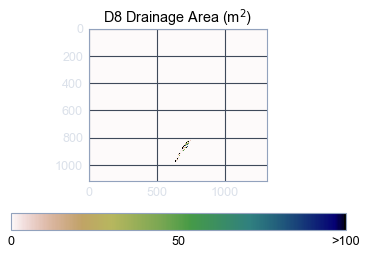

In [30]:
fig, ax = plt.subplots()

cax = ax.imshow(watershed_D8, interpolation='nearest', 
                cmap='gist_earth_r', vmax = 100)
ax.set_title('D8 Drainage Area (m$^2$)', color = 'Black')

cbar = fig.colorbar(cax, ticks=[0, 50, 100], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '50', '>100'], color = 'Black')
#plt.axis('off')
plt.show()

In [ ]:
np.flip(grid_of_flow_widths, 0).round(2);

# Run with variable runoff rate set by flow width (D8)

In [ ]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg1 = RasterModelGrid((rows,cols), 1);
z2 = mg1.add_field('topographic__elevation', flow_acc_surf, at = 'node');
runoff_rate = grid_of_flow_widths
_ = mg1.add_field('node', 'water__unit_flux_in', runoff_rate, noclobber=False)

In [ ]:
#mg1.set_watershed_boundary_condition(z2)

In [ ]:
#mg1.set_watershed_boundary_condition_outlet_id(978620, z2)

In [ ]:
#imshow_grid(mg1, mg.status_at_node, color_for_closed='blue')

In [ ]:
sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg1,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorD8');
(flow_acc, q) = fa.accumulate_flow();
#fa.run_one_step()
fd = FlowDirectorD8(mg1, 'topographic__elevation');
fd.direct_flow();
#fd.run_one_step()

In [ ]:
mg1.at_node.keys();

In [ ]:
da1 = np.array(mg1.at_node['drainage_area'].round(4));
frn1 = mg1.at_node['flow__receiver_node'];
swd = mg1.at_node['surface_water__discharge'];
Q = swd.reshape(mg.shape).round(2)
drainage_area_mg1 = da1.reshape(mg1.shape).astype('float64');
grid_nodes = (mg1.nodes).reshape(mg1.shape[0] * mg1.shape[1],);
flow_rec_surf_rows = cols * rows;

In [ ]:
plt.figure()
drainage_plot(mg1, 'drainage_area')

In [ ]:
np.flip(drainage_area_mg1, 0);

In [ ]:
np.flip(Q.round(1), 0);

In [ ]:
gully_discharge = drainage_area_mg1 * watershed_mask
gully_discharge_sca = Q * watershed_mask

In [ ]:
np.amax(gully_discharge)

In [ ]:
np.amax(gully_discharge_sca)

In [ ]:
fig, ax = plt.subplots()

cax = ax.imshow(drainage_area_mg1[740:750, 430:450], interpolation='nearest', 
                cmap='gist_earth_r', vmax = 100)
ax.set_title('D8 Drainage Area (m$^2$)', color = 'Black')

cbar = fig.colorbar(cax, ticks=[0, 50, 100], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '50', '>100'], color = 'Black')
#plt.axis('off')
plt.show()

# Find flow__receiver_proportions using (M8)

In the D8 case runoff_rate is set by the array grid_of_flow_widths because it is simply an array that considers the width of flow for either diagonal or cardinal. In the M8 case below, the array to be used as an input to runoff_rate is called width_factor. This difference in terminology reflects the difference in what the values determining runoff_rate actually represent.

M8 can have up to 8 directions of flow and in any combination of proportions summing to 1. This is handled by:
1. -finding the receiver proportions of each grid cell, 
2. -multiplying each proportion by either 1/x for cardinals or 1/(sqrt(2)* x) for diagonals, 
3. -multiplying the result for each direction found from step 2 by the flow accumulation value of the given grid cell,
4. -summing the results for all 8 directions (giving a new adjusted flow accumulation value),
5. -dividing the value calculated in step 5 by the original flow accumulation value.

This process will always return a fraction between 0 and 1 to be used as a runoff_rate coefficient. 

NOTE: The result from this is different to assigning flow in cardinal directions as 1/x and in diagonal directions as 1/sqrt(2) * x. Esentially it takes the increased flow width from the diagonal directions and distributes it to all directions.

In [16]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg2 = RasterModelGrid((rows,cols), 1);
z3 = mg2.add_field('topographic__elevation', flow_acc_surf, at = 'node');

In [ ]:
#mg2.set_watershed_boundary_condition(z3)

In [17]:
sfb = SinkFillerBarnes(mg2, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg2,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
(flow_acc, q) = fa.accumulate_flow();
#fa.run_one_step()
fd = FlowDirectorMFD(mg2, 'topographic__elevation', diagonals = True);
fd.direct_flow();
#fd.run_one_step()

In [18]:
da2 = np.array(mg2.at_node['drainage_area'].round(4));
frn2 = mg2.at_node['flow__receiver_node'];
frp2 = mg2.at_node['flow__receiver_proportions'];
drainage_area_mg2 = da2.reshape(mg2.shape).astype('float64');
grid_nodes = (mg2.nodes).reshape(mg2.shape[0] * mg2.shape[1],);
flow_rec_surf_rows = cols * rows;

In [19]:
width_array = np.copy(frp2);
width_array[:,4:] = np.multiply(width_array[:,4:], 1/np.sqrt(2));
width_factor = np.sum(width_array, 1);

# Run M8 with runoff set by width_factor above.

In [20]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg3 = RasterModelGrid((rows,cols), 1);
z4 = mg3.add_field('topographic__elevation', flow_acc_surf, at = 'node');
runoff_rate = width_factor
_ = mg3.add_field('node', 'water__unit_flux_in', runoff_rate, noclobber=False)

In [ ]:
#mg3.set_watershed_boundary_condition(z4)

In [21]:
sfb = SinkFillerBarnes(mg3, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg3,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
(flow_acc, q) = fa.accumulate_flow();
#fa.run_one_step()
fd = FlowDirectorMFD(mg3, 'topographic__elevation', diagonals = True);
fd.direct_flow();
#fd.run_one_step()

In [22]:
da3 = np.array(mg3.at_node['drainage_area'].round(4));
frn3 = mg3.at_node['flow__receiver_node'];
swd1 = mg3.at_node['surface_water__discharge'];
Q1 = swd1.reshape(mg3.shape).round(2);
drainage_area_mg3 = da3.reshape(mg3.shape).astype('float64');
grid_nodes = (mg3.nodes).reshape(mg3.shape[0] * mg3.shape[1],);
flow_rec_surf_rows = cols * rows;

In [31]:
gully_discharge = drainage_area_mg3 * watershed_mask
gully_discharge_sca = Q1 * watershed_mask

In [32]:
np.amax(gully_discharge)

4027.9472000000001

In [33]:
np.amax(gully_discharge_sca)

3449.3200000000002

In [ ]:
plt.imshow(Q1, cmap="gist_earth_r");
plt.colorbar();

# Extract watershed and compare results of four alternatives above.

In [ ]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [ ]:
np_array_to_Geotiff('fann_0_D8_sca.tif', input_geotiff, specific_catchment_area, drainage_area.dtype)